In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from PIL import Image

import torch
import torch.nn.functional as F

from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import process_images, tokenizer_image_token, get_model_name_from_path

from utils import (
    load_image, 
    aggregate_llm_attention, aggregate_vit_attention,
    heterogenous_stack,
    show_mask_on_image
)

/gpfs/users/restrepoda/.conda/envs/biomed-gpt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-02-25 19:32:23,942] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
from torchvision.transforms import ToPILImage, Grayscale

def show_image(img_tensor):
    image = ToPILImage()(Grayscale()(img_tensor[0]))

    #image = Image.open()
    
    # Display the image
    plt.imshow(image, cmap="gray")
    plt.axis('off') 
    plt.show()

    print(f'shape: {mimic_img_tensor.shape}')
    print()

In [3]:
from src.models import load_llava_med
model, processor = load_llava_med(model_id="microsoft/llava-med-v1.5-mistral-7b", quantization="16b", return_attention=True, return_logits=True, conv_mode = "mistral_instruct")

/gpfs/users/restrepoda/.conda/envs/biomed-gpt/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using the legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565
You are using a model of type llava_mistral to instantiate a model of type llava. This is not supported for all configurations of models and can yield errors.
Loading checkpoint shards: 100%|██████████| 4/4 [01:10<00:00, 17.75s/it]
Some weights of LlavaLlamaForCausalLM were not initialized from the model checkpoint at microsoft/llava-med-v1.5-mistral-7b and are new

In [4]:
# List to store attention maps
attention_maps = []

# Define a hook function to save attention maps
def save_attention_hook(module, input, output):
    attention_maps.append(output)

# Register the forward hook on each layer in the vision tower
for name, module in model.get_vision_tower().named_modules():
    if name.lower().endswith('self_attn'): 
        module.register_forward_hook(save_attention_hook)


### Get sample data

In [5]:
from src.datasets import load_mimic, load_mbrset, load_medeval

metadata_test = load_mimic(train=False, validation=False,check_images=False)
row_mimic = metadata_test.iloc[0]

_, _, metadata_test = load_medeval()
row_medeval = metadata_test.iloc[0]

Loading MIMIC dataset from /gpfs/workdir/restrepoda/datasets/MIMIC
Reading test data...
Reading text from zip file...
Loading VLMed dataset from /gpfs/workdir/restrepoda/datasets/VLMed
Images are stored in /gpfs/workdir/restrepoda/datasets/VLMed/Dataset/['Test', 'Validation', or 'Training']


In [6]:
from src.prompts import predict_dataset

text_mimic, image_mimic = predict_dataset(row_mimic, dataset='mimic', only_prompt=True)
text_medeval, image_medeval = predict_dataset(row_medeval, dataset='medeval', only_prompt=True)

### Images

### Preprocesing

#### https://github.com/microsoft/LLaVA-Med/blob/ce6cc507bb540fab453dec2def539856423e0f38/llava/model/builder.py#L76
#### Is just imagenet normalization

`model.get_vision_tower().image_processor`

```
CLIPImageProcessor {
  "crop_size": {
    "height": 336,
    "width": 336
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "CLIPFeatureExtractor",
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 336
  }
}
```

In [7]:
mimic_img_tensor = processor.process_image(image_mimic)
medeval_img_tensor = processor.process_image(image_medeval)

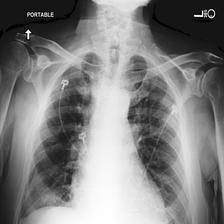

In [8]:
#show_image(mimic_img_tensor)
image_mimic

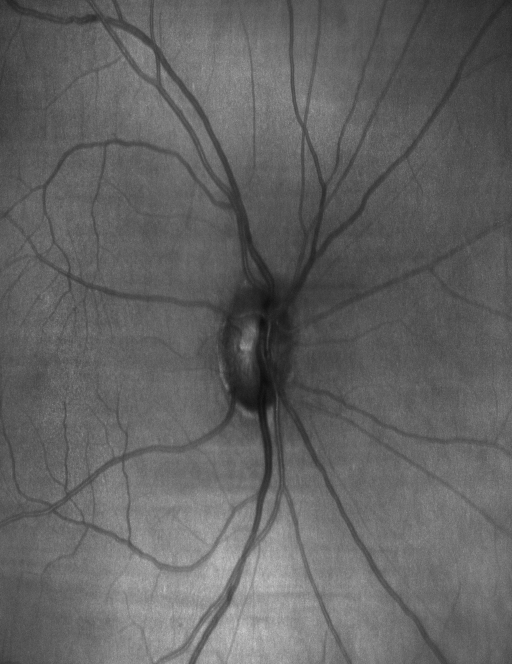

In [9]:
#show_image(medeval_img_tensor)
image_medeval

### Image processing

/gpfs/users/restrepoda/.conda/envs/biomed-gpt/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading MIMIC dataset from /gpfs/workdir/restrepoda/datasets/MIMIC
Reading test data...
Reading text from zip file...


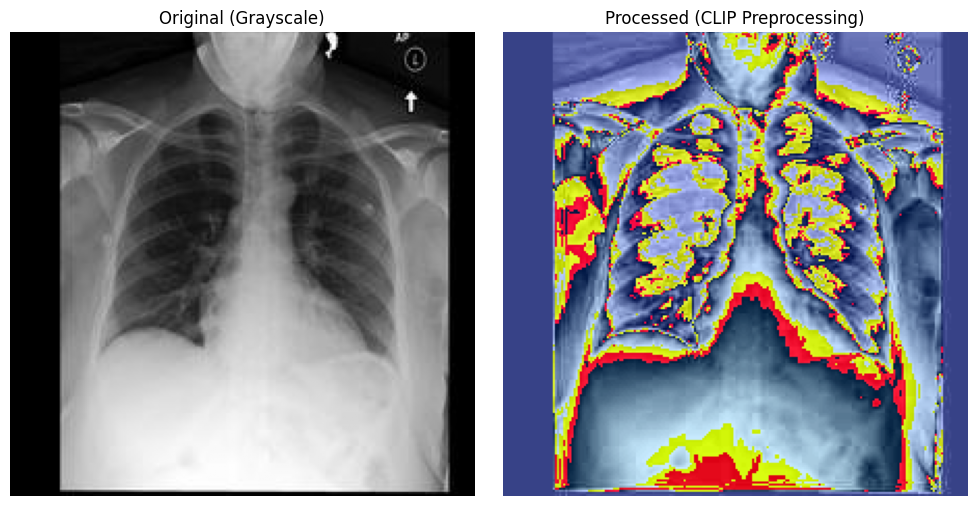

Saved original image to original_images/original_image_0.png
values: (0, 255)
Saved processed image to processed_images/processed_image_0.png
min value: -1.7922625541687012 max value: 2.1458969116210938


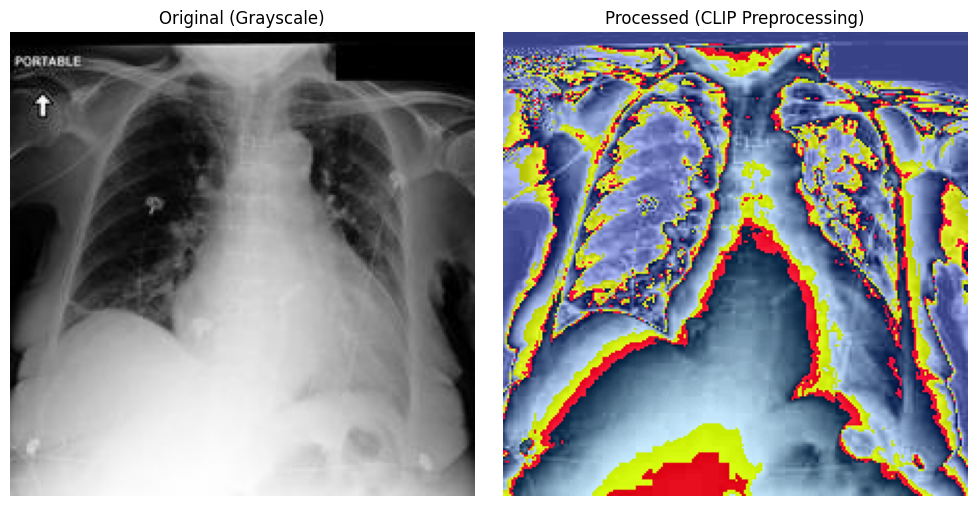

Saved original image to original_images/original_image_1.png
values: (0, 255)
Saved processed image to processed_images/processed_image_1.png
min value: -1.7922625541687012 max value: 2.1458969116210938


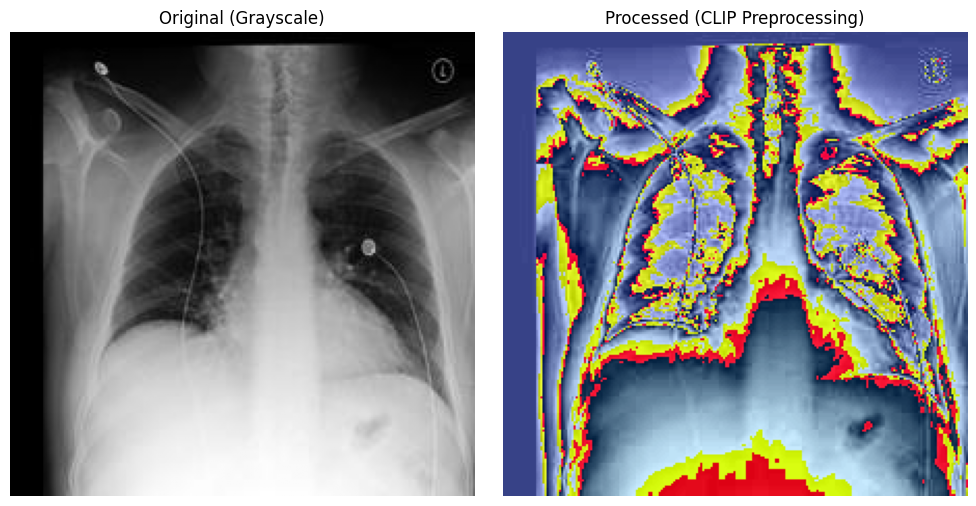

Saved original image to original_images/original_image_2.png
values: (0, 255)
Saved processed image to processed_images/processed_image_2.png
min value: -1.7922625541687012 max value: 2.1458969116210938


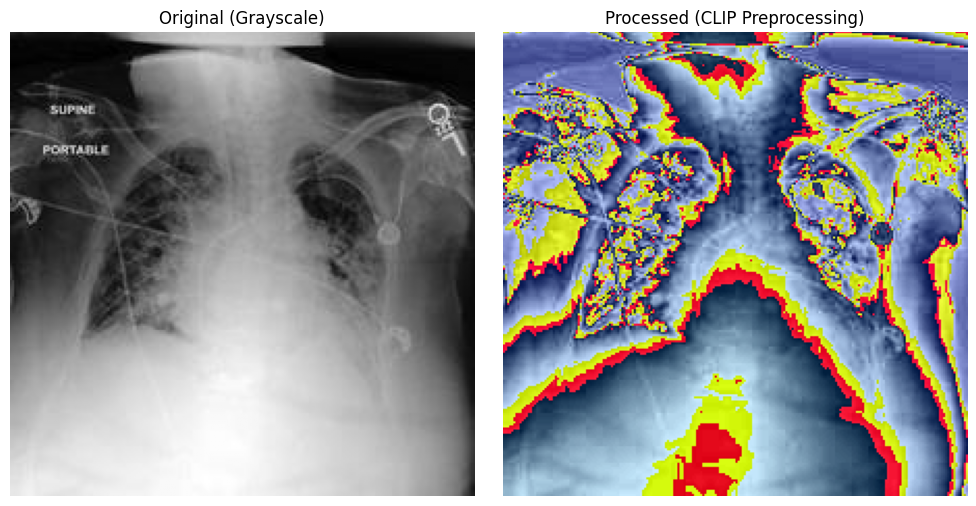

Saved original image to original_images/original_image_3.png
values: (0, 255)
Saved processed image to processed_images/processed_image_3.png
min value: -1.7922625541687012 max value: 2.1458969116210938


In [10]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import matplotlib.pyplot as plt
import os

# Load processor and model
processor_clip = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Paths to save images
output_dir_original = "original_images"
output_dir_processed = "processed_images"
os.makedirs(output_dir_original, exist_ok=True)
os.makedirs(output_dir_processed, exist_ok=True)

# Assuming `metadata_test` is already loaded with file paths
metadata_test = load_mimic(train=False, validation=False,check_images=False)
test_images = metadata_test.loc[8000:8003, 'filepath']

# Function to display and save original vs. processed images
def process_and_display_images(image_paths):
    for i, image_path in enumerate(image_paths):
        # Load grayscale image
        original_image = Image.open(image_path).convert("L")  # Ensure grayscale

        # Preprocess using CLIP processor
        inputs = processor_clip(images=original_image, return_tensors="pt")
        #processed_image_tensor = inputs["pixel_values"].squeeze(0)  # Remove batch dimension

        processed_pil_image = ToPILImage()((inputs["pixel_values"][0]))

        # Display original and processed images side by side
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(original_image, cmap="gray")
        axs[0].set_title("Original (Grayscale)")
        axs[0].axis("off")

        axs[1].imshow(processed_pil_image)
        axs[1].set_title("Processed (CLIP Preprocessing)")
        axs[1].axis("off")

        plt.tight_layout()
        plt.show()

        # Save original grayscale image
        original_image_path = os.path.join(output_dir_original, f"original_image_{i}.png")
        original_image.save(original_image_path)
        print(f"Saved original image to {original_image_path}")
        print(f"values: {original_image.getextrema()}")

        # Save processed image
        processed_image_path = os.path.join(output_dir_processed, f"processed_image_{i}.png")
        processed_pil_image.save(processed_image_path)
        print(f"Saved processed image to {processed_image_path}")
        print(f"min value: {inputs['pixel_values'][0].min()} max value: {inputs['pixel_values'][0].max()}")
        

# Process and display
process_and_display_images(test_images)